In [1]:
%matplotlib inline

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import torch.optim as optim
import gc

# from sklearn import svm, decomposition
from preprocess import remove_high_freq, whitening, from_cifar_to_np, from_submit_to_np
from plot import imshow
from util import trainNN, cal_accuracy, cal_class_accuracy, get_submit_result, export_to_file, print_accracy
from models import *

use_pca = False
use_forieum = False
export_csv = True
csv_name = 'res_resnet.csv'
BATCH_SIZE = 32

In [3]:
print('==> Preparing data..')
transform_train = transforms.Compose(
    [
#          transforms.RandomRotation(5),
         transforms.RandomCrop(32, padding=4),
#          transforms.RandomResizedCrop(32),
         transforms.RandomHorizontalFlip(),
#          transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),
         transforms.ToTensor(),
         transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
         remove_high_freq
    ]) if use_forieum else transforms.Compose(
    [
#          transforms.RandomRotation(5),
         transforms.RandomCrop(32, padding=4),
#          transforms.RandomResizedCrop(32),
         transforms.RandomHorizontalFlip(),
#          transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),
         transforms.ToTensor(),
         transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ]) 

transform_test = transforms.Compose(
    [
         transforms.ToTensor(),
         transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
         remove_high_freq
    ]) if use_forieum else transforms.Compose(
    [
         transforms.ToTensor(),
         transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ]) 


trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=0)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100,
                                         shuffle=False, num_workers=0)
submitdata = np.load("./test/y_test.npy").astype(np.uint8)

submit_images = [ transform_test(img) for img in submitdata]

submitloader = torch.utils.data.DataLoader(submit_images, batch_size=1,
                                          shuffle=False, num_workers=2)

# class MyDataset(torch.utils.data.Dataset):
#     def __init__(self,testdata,transform):
#         # show image
#         self.testdata=testdata
#         self.len = testdata.shape[0]
#         self.transform=transform

#     def __getitem__(self, index):
#         img = self.transform(self.testdata[index])
#         return img

#     def __len__(self):
#         return self.len

# submitset = MyDataset(testdata=submitdata, transform=transform_test)
# submitloader = torch.utils.data.DataLoader(submitset, batch_size=1, shuffle=False, num_workers=0)


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified


In [4]:
trainX, trainY = from_cifar_to_np(trainloader)
if not use_forieum:
    trainX = np.reshape(trainX, (50000, 3072))
print(trainX.shape)
print(trainY.shape)

(50000, 3072)
(50000,)


In [5]:
testX, testY = from_cifar_to_np(testloader)
if not use_forieum:
    testX = np.reshape(testX, (10000, 3072))
print(testX.shape)
print(testY.shape)

(10000, 3072)
(10000,)


In [6]:
submitX = from_submit_to_np(submitloader)
if not use_forieum:
    submitX = np.reshape(submitX, (12000, 3072))
print(submitX.shape)

(12000, 3072)


In [7]:
# Assume that we are on a CUDA machine, then this should print a CUDA device:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


torch.Size([128, 3, 32, 32])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


  car plane horse  ship  deer  frog  deer   car


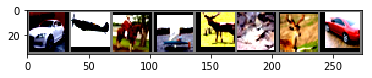

In [8]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# print(images)
print(images.size())

# show images in a batch, which contains 8 images
imshow(torchvision.utils.make_grid(images[0:8]))

# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(8)))

In [9]:
print('==> Building model..')
# net = SeventySevenNet()
# net = ResNet18()
# net = LargeNet()
# net = VGG('VGG19')
net = net.to(device)
criterion = nn.CrossEntropyLoss()

==> Building model..


In [10]:
for i in range(3): 
    optimizer = optim.Adam(net.parameters(), lr=1e-3, weight_decay=0.002)
    trainNN(net, trainloader, optimizer, criterion,  4)

    print('Accuracy of the network on the 10000 test images: %f %%' % (
        100 * cal_accuracy(net, testloader)))
    print('Accuracy of the network on the train images: %f %%' % (
        100 * cal_accuracy(net, trainloader)))

Training starts
[1,   100] double loss: 0.0153885
[1,   200] double loss: 0.0128407
[1,   300] double loss: 0.0121112
[2,   100] double loss: 0.0106378
[2,   200] double loss: 0.0101384
[2,   300] double loss: 0.0094393
[3,   100] double loss: 0.0086984
[3,   200] double loss: 0.0084596
[3,   300] double loss: 0.0080579
[4,   100] double loss: 0.0076794
[4,   200] double loss: 0.0075813
[4,   300] double loss: 0.0072052
Accuracy of the network on the 10000 test images: 69.860000 %
Accuracy of the network on the train images: 69.446000 %
Training starts
[1,   100] double loss: 0.0070849
[1,   200] double loss: 0.0067392
[1,   300] double loss: 0.0067860
[2,   100] double loss: 0.0063407
[2,   200] double loss: 0.0064480
[2,   300] double loss: 0.0062226
[3,   100] double loss: 0.0060390
[3,   200] double loss: 0.0061443
[3,   300] double loss: 0.0061166
[4,   100] double loss: 0.0057892
[4,   200] double loss: 0.0057275
[4,   300] double loss: 0.0057053
Accuracy of the network on the 10

In [11]:
for i in range(2): 
    optimizer = optim.Adam(net.parameters(), lr=1e-4, weight_decay=0.002)
    trainNN(net, trainloader, optimizer, criterion,  7)

    print('Accuracy of the network on the 10000 test images: %f %%' % (
        100 * cal_accuracy(net, testloader)))
    print('Accuracy of the network on the train images: %f %%' % (
        100 * cal_accuracy(net, trainloader)))

Training starts
[1,   100] double loss: 0.0045772
[1,   200] double loss: 0.0044492
[1,   300] double loss: 0.0042278
[2,   100] double loss: 0.0042295
[2,   200] double loss: 0.0041753
[2,   300] double loss: 0.0041085
[3,   100] double loss: 0.0041979
[3,   200] double loss: 0.0040697
[3,   300] double loss: 0.0041154
[4,   100] double loss: 0.0040087
[4,   200] double loss: 0.0041002
[4,   300] double loss: 0.0040538
[5,   100] double loss: 0.0039736
[5,   200] double loss: 0.0039914
[5,   300] double loss: 0.0041034
[6,   100] double loss: 0.0039402
[6,   200] double loss: 0.0040559
[6,   300] double loss: 0.0039283
[7,   100] double loss: 0.0039122
[7,   200] double loss: 0.0038773
[7,   300] double loss: 0.0039102
Accuracy of the network on the 10000 test images: 81.330000 %
Accuracy of the network on the train images: 83.066000 %
Training starts
[1,   100] double loss: 0.0037900
[1,   200] double loss: 0.0039418
[1,   300] double loss: 0.0038847
[2,   100] double loss: 0.0038378

In [12]:
for i in range(3): 
    optimizer = optim.Adam(net.parameters(), lr=3e-5, weight_decay=0.002)
    trainNN(net, trainloader, optimizer, criterion,  1)

    print('Accuracy of the network on the 10000 test images: %f %%' % (
        100 * cal_accuracy(net, testloader)))
    print('Accuracy of the network on the train images: %f %%' % (
        100 * cal_accuracy(net, trainloader)))

Training starts
[1,   100] double loss: 0.0035713
[1,   200] double loss: 0.0035667
[1,   300] double loss: 0.0035294
Accuracy of the network on the 10000 test images: 82.000000 %
Accuracy of the network on the train images: 84.238000 %
Training starts
[1,   100] double loss: 0.0035157
[1,   200] double loss: 0.0035198
[1,   300] double loss: 0.0035480
Accuracy of the network on the 10000 test images: 82.100000 %
Accuracy of the network on the train images: 84.194000 %
Training starts
[1,   100] double loss: 0.0035337
[1,   200] double loss: 0.0035494
[1,   300] double loss: 0.0036235
Accuracy of the network on the 10000 test images: 82.080000 %
Accuracy of the network on the train images: 84.304000 %


In [13]:
for i in range(5): 
    optimizer = optim.Adam(net.parameters(), lr=1e-4, weight_decay=0.002)
    trainNN(net, trainloader, optimizer, criterion,  1)

    print('Accuracy of the network on the 10000 test images: %f %%' % (
        100 * cal_accuracy(net, testloader)))
    print('Accuracy of the network on the train images: %f %%' % (
        100 * cal_accuracy(net, trainloader)))

Training starts
[1,   100] double loss: 0.0036301
[1,   200] double loss: 0.0035170
[1,   300] double loss: 0.0037130
Accuracy of the network on the 10000 test images: 82.080000 %
Accuracy of the network on the train images: 84.190000 %
Training starts
[1,   100] double loss: 0.0036802
[1,   200] double loss: 0.0036535
[1,   300] double loss: 0.0035507
Accuracy of the network on the 10000 test images: 81.750000 %
Accuracy of the network on the train images: 84.124000 %
Training starts
[1,   100] double loss: 0.0036104
[1,   200] double loss: 0.0035719
[1,   300] double loss: 0.0035757
Accuracy of the network on the 10000 test images: 82.080000 %
Accuracy of the network on the train images: 84.360000 %
Training starts
[1,   100] double loss: 0.0035671
[1,   200] double loss: 0.0036198
[1,   300] double loss: 0.0035131
Accuracy of the network on the 10000 test images: 82.390000 %
Accuracy of the network on the train images: 84.086000 %
Training starts
[1,   100] double loss: 0.0035606
[1

In [14]:
for i in range(4): 
    optimizer = optim.Adam(net.parameters(), lr=1e-5, weight_decay=0.002)
    trainNN(net, trainloader, optimizer, criterion,  1)

    print('Accuracy of the network on the 10000 test images: %f %%' % (
        100 * cal_accuracy(net, testloader)))
    print('Accuracy of the network on the train images: %f %%' % (
        100 * cal_accuracy(net, trainloader)))

Training starts
[1,   100] double loss: 0.0034836
[1,   200] double loss: 0.0033922
[1,   300] double loss: 0.0034098
Accuracy of the network on the 10000 test images: 82.740000 %
Accuracy of the network on the train images: 84.788000 %
Training starts
[1,   100] double loss: 0.0034255
[1,   200] double loss: 0.0033439
[1,   300] double loss: 0.0034413
Accuracy of the network on the 10000 test images: 82.680000 %
Accuracy of the network on the train images: 84.780000 %
Training starts
[1,   100] double loss: 0.0033731
[1,   200] double loss: 0.0033993
[1,   300] double loss: 0.0034254
Accuracy of the network on the 10000 test images: 82.690000 %
Accuracy of the network on the train images: 84.790000 %
Training starts
[1,   100] double loss: 0.0033983
[1,   200] double loss: 0.0034371
[1,   300] double loss: 0.0033717
Accuracy of the network on the 10000 test images: 82.720000 %
Accuracy of the network on the train images: 84.872000 %


In [15]:
params = list(net.parameters())
print(len(params))

44


In [16]:
cal_class_accuracy(net, testloader)

Accuracy of plane : 93 %
Accuracy of   car : 100 %
Accuracy of  bird : 73 %
Accuracy of   cat : 65 %
Accuracy of  deer : 81 %
Accuracy of   dog : 71 %
Accuracy of  frog : 77 %
Accuracy of horse : 90 %
Accuracy of  ship : 87 %
Accuracy of truck : 89 %


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


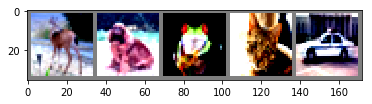

In [17]:
images = submit_images[2100:2105]
imshow(torchvision.utils.make_grid(images))

(1, 3, 32, 32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


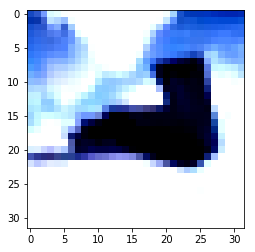

In [18]:
dataiter = iter(submitloader)
images = dataiter.next()
print(np.array(images).shape)
imshow(torchvision.utils.make_grid(images))

In [19]:
gc.collect()

2297

In [20]:
results = []
with torch.no_grad():
    for index, images in enumerate(submitloader):
        inputs = images.to(device)
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        results.append(predicted.cpu().numpy())


In [22]:
import pandas as pd
result_df = pd.DataFrame(
    list(results),
    columns=["Category"]
  )
result_df.index.name = "Index"
print(results[2])


result_df.to_csv("results/res_reproduce.csv")

[0]
